# **AI in Medicine**
## **Session 3**: Dimensionality reduction, Decision Trees, and Neural Networks

Welcome to the third programming workshop for the AI in Medicine series! 

Today we will be diving into some more advanced concepts in machine learning:
*    Unsupervised learning: Dimensionality Reduction with Principal Component Analysis (PCA). This topic was in the previous session but we didn't have enough time to cover it, so it is included here for you to go over
*    Supervised learning: Decision Trees and understanding Overfitting
*    Supervised learning: Neural Networks
*    Cross-validation

Before you begin reading and editing any code, make sure to make a personal copy of this notebook by clicking `File` --> `Save a Copy in Drive` so you can make changes to the code.

## Imports and loading the dataset
Let's start the necessary `import`s for our code. We will use the wines dataset again (from the previous session) to look at unsupervised dimensionality reduction, and then we will go back to the breast cancer dataset for the supervised learning topics.

**Confused about something?** Raise questions during the session or on Slack! Also remember that you can always Google a function or piece of code that you're not sure about and you will find lots of documentation explaining what is happening.

In [1]:
# Load the necessary python libraries
from sklearn import preprocessing, decomposition
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source
from IPython.display import SVG
import pandas as pd
import numpy as np
import scipy

%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size': 14,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'figure.figsize' : [12,8],
                     })

In [2]:
# Load the wine dataset into a variable, and then print a description of the dataset
dataset = load_wine()
print(dataset['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [3]:
# Lets store the dataset as a dataframe using the pandas library
df = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
df['Label'] = dataset['target']

# We will first standardize the data to have zero mean and a variance of 1, which usually
# stabilizes and improves performance in most machine learning algorithms. This is a common preprocessing step
scaler = preprocessing.StandardScaler().fit(df.iloc[:,:-1]) # Define a scaler which standardizes the data to have mean 0 and standard devation 1. This usually improves stability and performance
df_scaled = scaler.transform(df.iloc[:,:-1]) #Use the scaler to transform the training and test data
df_scaled = pd.DataFrame(df_scaled)

# **Unsupervised Learning**: Dimensionality Reduction with Principal Component Analysis (PCA)
When we were learning unsupervised clustering in previous session, we first chose to arbitrarily use and visualize the first two features. But these aren't necessarily the best features to work with, there could be some other combination of two (or more) features which better represent the data. 

If we cannot use all the features in our analysis, or we believe that all features we have collected in our data can be better represented by fewer features, how do we find the best features to use for analysis?

This is where we would use **dimensionality reduction**, which is another unsupervised learning technique. The purpose of dimensionality reduction is to find a combination of fewer features which best represent our data, without us needing to have any class/output labels associated with a particular outcome.

One of the most popular dimensionality reduction techniques is known as Principal Component Analysis (PCA), which finds linear combinations of features from the original dataset which best explains the majority of the variance. **NOTE:** Dimensionality reduction is different from feature selection, as dimensionality reduction results in new features which are combinations of original features in the dataset. Feature selection, on the other hand, preserves the original features. Both dimensionality reduction and feature selection are common steps in a pipeline before further machine learning analysis is used.

Let's now use PCA to find how many components are necessary to explain most of the variance in the wine dataset

The percent variance explained by the thirteen components is:  [36.1988481  19.20749026 11.12363054  7.06903018  6.56329368  4.93582332
  4.23867932  2.68074895  2.2221534   1.93001909  1.73683569  1.29823258
  0.79521489]


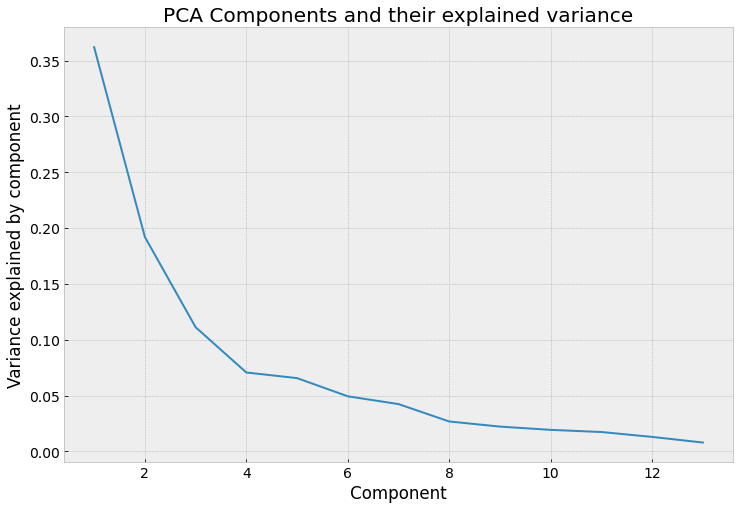

In [ ]:
pca = decomposition.PCA() #Define a PCA object
pca.fit(df_scaled) # Solve PCA on the standardized wine dataset
df_pca = pca.transform(df_scaled) # Transform wine dataset into the principal components as found by the PCA algorithm

# Let's visualize how important each component is by looking at how much variance each component explains:
plt.figure()
plt.plot(range(1,14), pca.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Variance explained by component')
plt.title('PCA Components and their explained variance')
print("The percent variance explained by the thirteen components is: ", pca.explained_variance_ratio_ * 100)

We can see that most of the variance in the datasets is explained by the first 4 principal components. That means that we could use the 4 principal components to explain most of the data and therefore use those as features instead of the original 13.

We can see how useful this concept is by visualizing the first two principal components and seeing how straightforward it would be to cluster into the three classes compared to previously when we were using the first two features. The first two principal components and the first two features of the dataset are scatter plotted separately below to show you the usefulness of dimensionality reduction

Text(0.5, 1.0, 'With Ground Truth Labels')

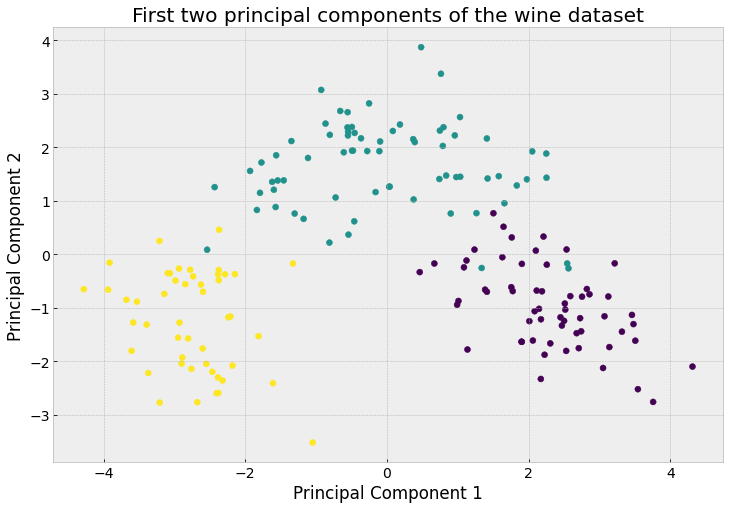

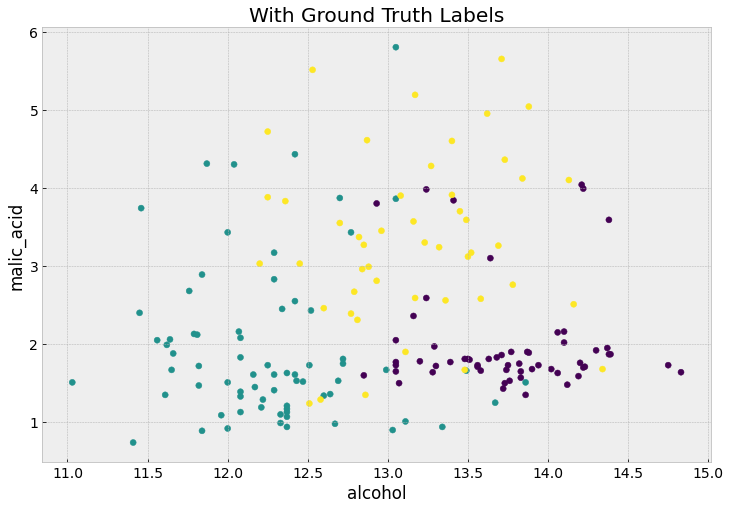

In [ ]:
# Scatter plot the first two components and their true class labels
plt.figure()
plt.scatter(df_pca[:,0], df_pca[:,1], c=df['Label'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two principal components of the wine dataset')

# Satter plot of the first two features with true class labels
feature_1 = 0
feature_2 = 1
plt.figure()
plt.scatter(df.iloc[:,feature_1], df.iloc[:,feature_2], c=df['Label'])
plt.xlabel(df.columns[feature_1])
plt.ylabel(df.columns[feature_2])
plt.title('With Ground Truth Labels')

# **Supervised Learning**: Decision Trees for Classification

This session we will look at another supervised learning technique, Decision Trees. Recall that last session we looked at logistic regression, which is suitable for classifying data that is *linearly separable*. Decision trees, on the other hand, can learn non-linear classification boundaries which is suitable for more complex datasets. Another benefit of decision trees is that they are **easy to interpret**! This is because, for a trained decision tree classifier, you can directly view the decisions that are being made in the algorithm which lead to the final classification. As a result, decision trees are a great option for medical problems (such as reaching a diagnosis based on certain patient symptoms) where it is important to explain and understand how an algorithm reaches its decision.

Once again, we will be analyzing the breast cancer dataset. We will use decision trees to learn how to predict benign from malignant tumors, and we will investigate how the accuracy changes as we change the depth of the decision tree.

**Reminder:** the breast cancer dataset has 539 tumor cases with 30 features each. Feel free to visualize and plot the features to explore the data

In [4]:
# Load breast cancer dataset and store as a Pandas dataframe. This code is the same as used in the previous session
cancer = load_breast_cancer()
scaler = preprocessing.StandardScaler().fit(cancer.data) # Define a scaler which standardizes the data to have mean 0 and standard devation 1. This usually improves stability and performance
cancer_data_scaled = scaler.transform(cancer.data) #Use the scaler to transform the training and test data

## Training a decision tree and understanding overfitting:

`sklearn` provides all the code necessary to create and train a decision tree. 

One of the most important parameters that we need to settle on for a decision tree is its maximum depth, which is essentially how many levels of decisions we want the algorithm to make before arriving at the final classification. If we pick a decision tree with too few levels (e.g. `max_depth = 1`), then it will not be complex enough to accurately differentiate between benign and malignant tumors. On the other hand, if our decision tree has too many levels (e.g. `max_depth = 15` for our dataset), then the algorithm will try to perfectly classify the training set over 15 levels of questions. The issue here is that this perfect classification will not generalize to the validation set, and so the validation accuracy will be poor. We will do a simple experiment to figure out how to pick the appropriate decision tree depth, and you can use this type of analysis in the future to settle on other important parameters for algorithms.

This will be our experiment:
1.  Split the dataset into training and validation sets with a split of 75%/25%
2.  Train 15 different decision tree classifiers with exactly the same parameters, with the exception of maximum depth which varies from 1 to 15. 
3.  Visualize training and validation set accuracy for each decision tree
4.  Visualize the decision tree with the most appropriate maximum depth
5. Visualize the best decision tree results as a confusion matrix



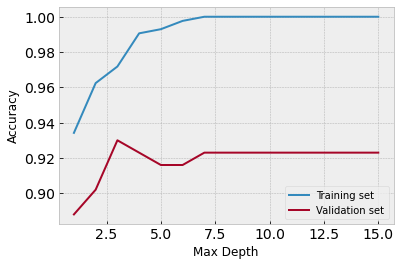

In [6]:
# Split the dataset into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(cancer_data_scaled, cancer.target, random_state=13)

# Create empty variables to store the decision tree accuracy results
training_accuracy = []
validation_accuracy = []

# Define the range of decision tree as 1 - 15
max_dep = range(1,16)

# Use a for loop to try each of the maximum depth decision trees, and store the scores in the appropriate lists
for md in max_dep:
    tree = DecisionTreeClassifier(max_depth=md,random_state=0)
    tree.fit(X_train,y_train)
    training_accuracy.append(tree.score(X_train, y_train))
    validation_accuracy.append(tree.score(X_validation, y_validation))

# Plot the tree depths against training and validation set accuracies
plt.figure()
plt.plot(max_dep,training_accuracy, label='Training set')
plt.plot(max_dep,validation_accuracy, label='Validation set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend()
plt.show()

# What is the optimal tree depth?
# Can you explain why the training set accuracy keeps increasing with depth?

The training accuracy is:  0.971830985915493
The validation accuracy is:  0.9300699300699301


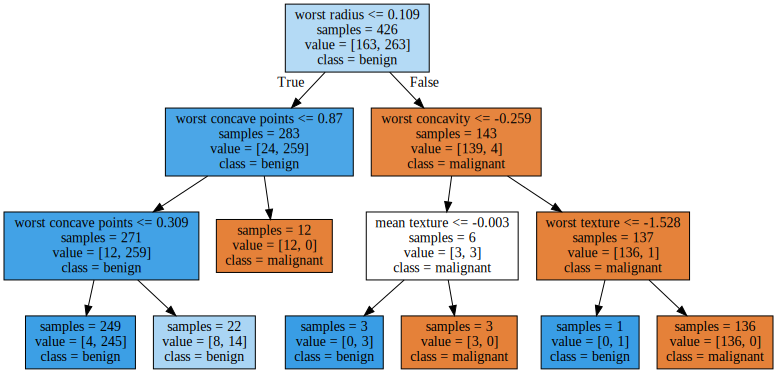

In [ ]:
# By looking at the above accuracy plot, the best validation accuracy is when max_depth is 3. 
# Above this value, the model isn't as accurate on the validation set.
# Let's re-train the tree with max_depth = 3

tree = DecisionTreeClassifier(max_depth=3,random_state=0)
tree.fit(X_train,y_train)
training_accuracy = tree.score(X_train, y_train)
validation_accuracy = tree.score(X_validation, y_validation)
print('The training accuracy is: ', training_accuracy)
print('The validation accuracy is: ', validation_accuracy)

# Visualize decision tree
graph = Source(export_graphviz(tree, out_file=None, class_names=['malignant','benign'], feature_names=cancer.feature_names, impurity=False, filled=True))
SVG(graph.pipe(format='svg'))

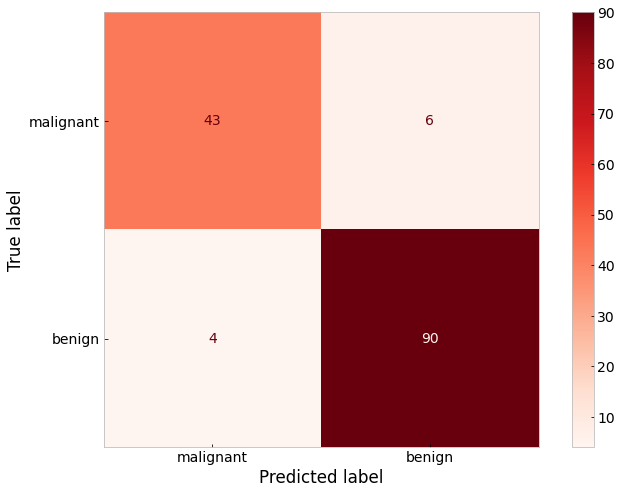

In [ ]:

# Visualize results as a confusion matrix
fig, ax = plt.subplots()
plot_confusion_matrix(tree, X_validation, y_validation,
                       display_labels=['malignant','benign'],
                                cmap=plt.cm.Reds,ax=ax)
plt.grid(False)
plt.show()

From our little experiment, we can see that a **maximum depth greater than 3 results in an overfitted model**. We can also see from the top level of the decision tree itself that the most important feature in the dataset by which to sort tumor classes is the 'worst radius' feature.

# **Supervised Learning:** Cross-validation
Do you feel that our above experiment was conclusive enough? Are you 100% certain that the best value of maximum depth is 3, and that the most discriminative feature really is worst radius?

You may have realized that the maximum depth selection process is sensitive to how the data is split into the training and validation sets. What if we repeated the training/validation split so there were different samples in each of the sets? You can try this by changing the `random_state` above from `13` to another number (in the line `X_train, X_validation, y_train, y_validation = train_test_split(..., random_state=13)`

However, a more systematic way of seeing how different training/validation splits affects the overall analysis is by performing cross-validation. Here you split the data into $n$ different 'folds' so that in each fold the data in training and validation is different. The diagram below visualizes this concept - the top is what we did above and the grid is showing '5-fold cross-validation'


<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png>

We will do a second experiment now using a 5-fold cross validation. We will vary maximum depth between 1 and 15 as before, but we will try each maximum depth for each of 5 different training/validation folds. Therefore we should expect $15$ max_depths $\times5$ folds $=75$ accuracies for the training and validation set each.

Luckily for us, the `sklearn` library also provides a `cross_validate` function to create cross-validation splits, so we don't have to manually code that.

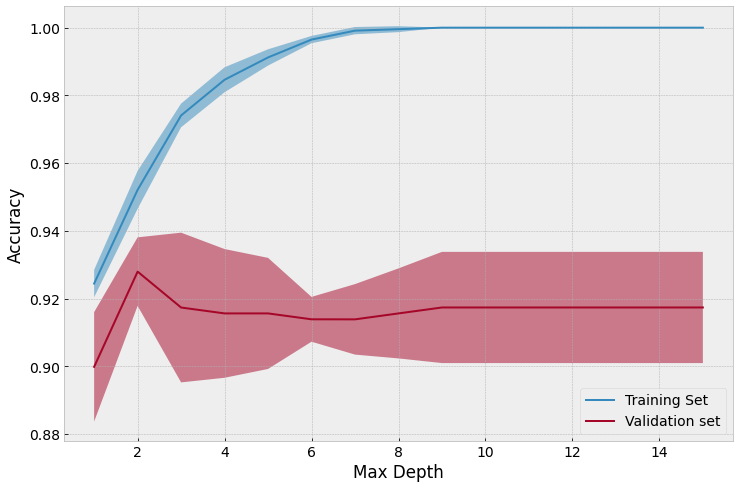

In [ ]:
# Create empty variables to store the decision tree accuracy results
training_accuracy = []
validation_accuracy = []
scoring={'accuracy'}

# Define the range of decision tree depths you want to train
max_dep = range(1,16)

# Use a for loop to test each of the 15 maximum depth settings in the decision tree.
# *NOTE* This time we use the `cross_validate` function to get 5 results on the training and validation fold for each maximum depth!
for md in max_dep:
    tree = DecisionTreeClassifier(max_depth=md,random_state=0)
    results = cross_validate(tree, cancer_data_scaled, cancer.target, cv=5, scoring=scoring, return_train_score=True)
    training_accuracy.append(results['train_accuracy'])
    validation_accuracy.append(results['test_accuracy'])

# Now the train_accuracy and validation_accuracy lists contain 15 different lists, each with 5 accuracy values for each fold.
# Let's visualize all this information in the same line plot, by plotting the mean accuracies for each maximum depth +/- the standard deviations
training_acc_mean = np.mean(training_accuracy, axis=1)
training_acc_std = np.std(training_accuracy, axis=1)
val_acc_mean = np.mean(validation_accuracy, axis=1)
val_acc_std = np.std(validation_accuracy, axis=1)

plt.figure()
plt.plot(max_dep, training_acc_mean, label='Training Set')
plt.fill_between(max_dep, training_acc_mean-training_acc_std, training_acc_mean+training_acc_std, alpha=0.5)
plt.plot(max_dep, val_acc_mean, label='Validation set')
plt.fill_between(max_dep, val_acc_mean-val_acc_std, val_acc_mean+val_acc_std, alpha=0.5)
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend(loc='lower right')
plt.show()

Using 5-fold cross validation, we can come to a better conclusion that perhaps a max-depth of 2 is more appropriate as the absolute mean validation accuracy is higher. However, as you can see there is a significant error (standard deviation) so this difference is not necessarily statistically significant.

Feel free to play around with a different number cross-validation folds (adjusted using the `cv` input keyword to the `cross_validate` function), and different random states for the decision tree classifier. Also feel free to plot the best decision tree to see which features are the most important.

You can read more about [Decision Trees](https://scikit-learn.org/stable/modules/tree.html) and [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html) on the scikit-learn website.

# **Supervised Learning**: Neural Networks for Classification

It's finally time to train our first neural network! 

# Training a simple neural network

We will train a fully-connected neural network on all the features of our dataset. We will have two hidden layers with 5 and 2 neurons in each layer. Since we have 30 features and binary classification (there are only two output possibilites, tumor or no tumor), our neural network will look like this:


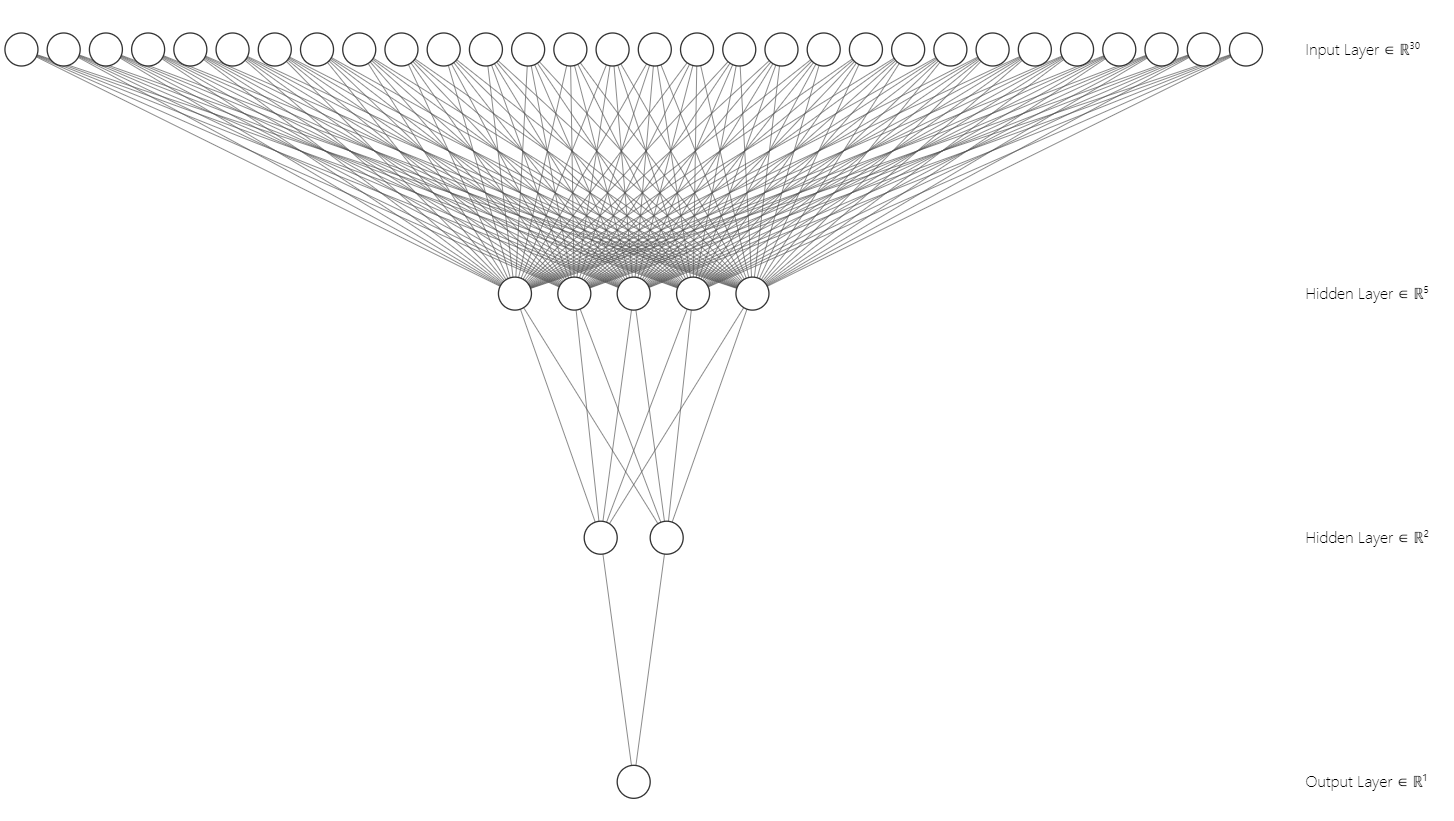

Training Accuracy:  0.9882629107981221
Validation Accuracy:  0.9790209790209791


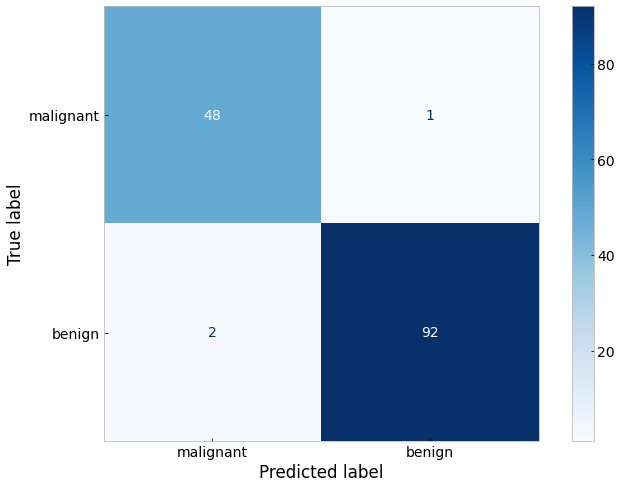

In [ ]:
# Using sklearn train a Neural Network on the scaled cancer data, and compare accuracies
# First define a neural network classifier using the 'adam' optimizer, with two hidden layers with 5 and 2 neurons respectively, with fixed random state of 1
neuralNet = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(5,2), max_iter = 5000, verbose=False, random_state=1) 
neuralNet.fit(X_train, y_train) #Fit the neural network to the training set

# Print the training and validation accuracies
print('Training Accuracy: ', neuralNet.score(X_train, y_train))
print('Validation Accuracy: ', neuralNet.score(X_validation, y_validation))

# Plot a confusion matrix to visualize how the neural network performs in terms of true positives, false positives, etc
fig, ax = plt.subplots()
plot_confusion_matrix(neuralNet, X_validation, y_validation,
                                display_labels=['malignant','benign'],
                                cmap=plt.cm.Blues, ax=ax)
plt.grid(False)
plt.show()

Even with arbitrarily chosen neural network hyperparameters (i.e. 5 and then 2 neurons, a single training/validation split, etc.) we achieved better results than the decision tree classifier. However, interpreting the weights of the neural network and how each sample is classified is not as easy and therefore requires us to trust that the neural network has learned a meaningful decision algorithm which would generalize to new patient tumors. 

Try to scientifically find the best parameters for a neural network for the breast cancer dataset. Use the concept of `for` loops and cross-validation to explore how the training and validation accuracies change. Is the network learning anything useful, is it underfitting or overfitting? You will quickly realize that a neural network is very sensitive to the settings you give it, and it does not take much to get large changes in accuracy. For example, re-run the above neural network code with 

# **Supervised Learning**: Convolutional Neural Networks for Classification

Many medical datasets now include images (e.g. patient X-rays, histopathology slides, etc.) Advances in computing have allowed neural network analysis to be extended to images for extremely high accuracy for medical imaging tasks, using convolutional neural networks (CNNs). 

We will show you how you can use a very popular CNN library, `PyTorch` (`torch`), to train a simple convolutional neural network architecture to classify between 10 classes of natural images with high accuracy. The code below does not build on any of the `sklearn` functions we have been using above, so read it slowly and carefully to understand it all. The tutorial is adapted from [pytorch.org](https://pytorch.org)

We will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

**NOTE:** We will be using the free GPU provided by Google Colab for training our CNN. Make sure you go to the menu above, select `Runtime` --> `Change runtime type`, select `GPU` and then save. Restart the runtime and run all cells.

In [ ]:
# Necessary PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {} for training".format(device))

Using cuda:0 for training


In [ ]:
# Download the CIFAR10 dataset and separate into training and test sets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


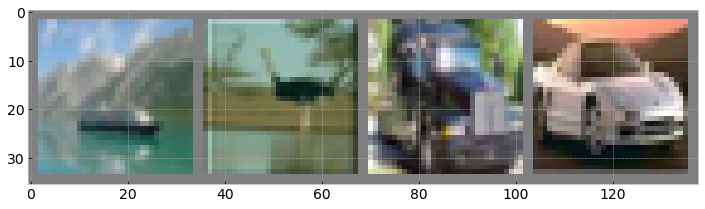

 ship  bird truck   car


In [ ]:
# Lets visualize some of the training set images. Re-run this cell to see new images

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Pick random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Defining our CNN model

PyTorch gives us a lot of flexibility in creating any type of CNN architecture we want. Below, we show have provided typical code to create a very conventional CNN for classifying into 10 categories

In [ ]:
# Define the blueprint for our architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create one CNN using our blueprint, put it on the GPU
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Defining our loss function and optimizer, and training the CNN
Just as with regular neural networks (like the one we trained above on the breast cancer dataset), we need to define an optimizer and loss function which will determine how our CNN learns. We will then create a training loop over which we will measure accuracy on the training and test sets.

In [ ]:
# We will use the multi-class cross entropy loss function
criterion = nn.CrossEntropyLoss()

# We will use the Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

#Now define a training loop which runs for 2 epochs (an epoch is one full run through all the training images)

for epoch in range(2):  # loop over the dataset 2 times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches (i.e. every 8000 images)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.887
[1,  4000] loss: 1.595
[1,  6000] loss: 1.500
[1,  8000] loss: 1.444
[1, 10000] loss: 1.415
[1, 12000] loss: 1.382
[2,  2000] loss: 1.305
[2,  4000] loss: 1.303
[2,  6000] loss: 1.277
[2,  8000] loss: 1.262
[2, 10000] loss: 1.243
[2, 12000] loss: 1.238
Finished Training


In [ ]:
# Evaluate the model's accuracy on the full test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


**~55% accuracy over ten classes** is pretty good, considering that randomly guessing would only achieve 10% accuracy. We can look at the accuracies for each class to see where the network is learning well and where it is underperforming. We can also plot a confusion matrix to get this information.

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
predicted_labels = []
true_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        true_labels.append(labels.detach().cpu().numpy())
        predicted_labels.append(predicted.detach().cpu().numpy())
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



Accuracy of plane : 63 %
Accuracy of   car : 76 %
Accuracy of  bird : 36 %
Accuracy of   cat : 28 %
Accuracy of  deer : 51 %
Accuracy of   dog : 50 %
Accuracy of  frog : 62 %
Accuracy of horse : 70 %
Accuracy of  ship : 71 %
Accuracy of truck : 65 %


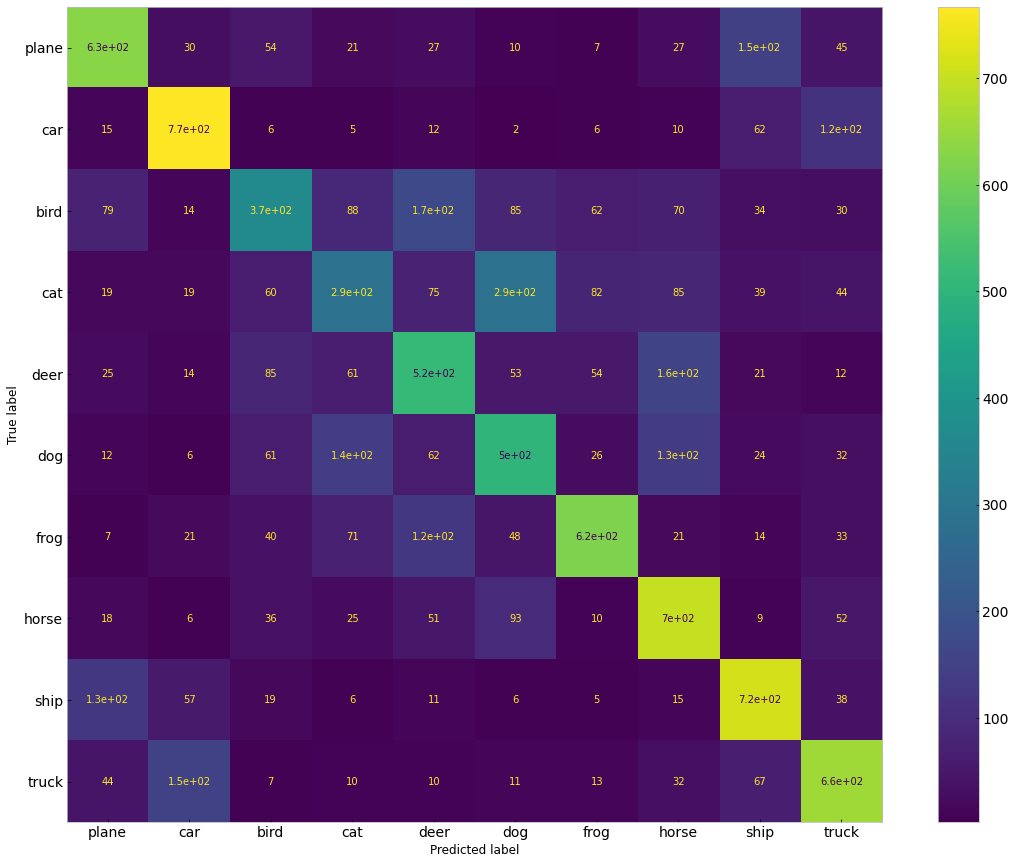

In [ ]:
# Plot confusion matrix
cmatrix = confusion_matrix(np.array(classes)[np.ravel(true_labels).astype(int)], np.array(classes)[np.ravel(predicted_labels).astype(int)], labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=classes)
fig,ax = plt.subplots(figsize=[20,15])
disp.plot(ax=ax)
plt.grid(False)
plt.show()

Hopefully this has made you interested in usefulness of machine learning and AI! You should explore other algorithms and datasets out there. In particular, you should read about and play around with CNNs to see how you can improve accuracy. Next time you work on a medical or healthcare related project, you can assess whether machine learning could be used to augment your analysis or create a prediction model.

Good luck!